#1 - Libraries and functions

In [1]:
import numpy as np
import pandas as pd
import math
import os
import csv
import matplotlib.pyplot as plt
import glob
import xlrd
from datetime import datetime, timedelta
import folium
import matplotlib.cm as cm
import calendar
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_data(anno):
    current_dir = os.getcwd()
    mydir = os.path.join(os.getcwd(), "/content/drive/MyDrive/Progetto/ingressi_orari/", str(anno)) #currentworkingdir/content/drive/MyDrive/Progetto/ingressi_orari/anno
    df = []
    for infile in sorted(glob.glob(os.path.join(mydir, "*.csv"))):
        print(infile)
        data = pd.read_csv(infile)
        df.append(data)

    df = pd.concat(df)
    if 'data' in df.columns and type(df['data'].iloc[0]) != 'datetime.date':
      df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d').dt.date


    os.chdir(current_dir)
    print(data.shape)
    return df

In [4]:
def process_data(df, anno):
    # add column for time range
    df['dataora'] = pd.to_datetime(df['dataora'], utc=True)
    df['ora'] = df['dataora'].dt.hour
    fasce_orarie = list(range(0, 25))  #  0 - 24 time slot usa 25
    df['fascia_oraria'] = pd.cut(df['ora'], bins=fasce_orarie, right=False)

    # hour and date
    df['data'] = df['dataora'].dt.date
    df['ora'] = df['dataora'].dt.time
    # drop the original column
    df = df.drop('dataora', axis=1)

    # consider just 2022/2023
    df = df[df["data"] > datetime.strptime(str(anno-1) + '-12-31', "%Y-%m-%d").date()]

    # delete the varco 89 - dato che non risulta avere dati di ingressi in nessun giorno
    df = df[df["id_varco"] != 89]

    return df

In [5]:
def to_data(giorno):     # Rimuovo dati errati
  d = datetime.strptime(giorno, "%Y-%m-%d").date()
  return d

In [6]:
def fixvalues_back(meteo):     # Rimuovo dati errati
    # Precipitazioni negative
    meteo.loc[meteo['precipitazioni']<0,'precipitazioni'] = 0
    # Temperature troppo alte/basse
    idx = meteo.loc[abs(meteo['temp'])> 50,'temp'].index
    for i in idx:
        if i == 0:
            print("Errore nella prima riga")
        else:
            if i>=0:
                if abs(meteo.loc[i-1, 'temp']) < 50:
                    meteo.loc[i, 'temp'] = meteo.loc[i-1, 'temp']
                else:
                    i = i-1

    return meteo

In [7]:
def separa_ingressi(df):
  # Creazione di una colonna 'ingressi_areac' per consentire la differenziazione tra 0 e 1
  df_copia = df.copy()
  df['ingressi_areac'] = 'ingressi_areac_' + df['areac'].astype(str)

  # Creazione della tabella pivot
  pivot_df = df.pivot_table(index=['id_varco', 'data'], columns='ingressi_areac', values='numero_transiti', aggfunc='sum').reset_index()

  # Rinomina delle colonne per una migliore chiarezza
  pivot_df.columns.name = None  # Rimuove il nome della colonna dall'intestazione
  pivot_df = pivot_df.rename(columns={'ingressi_areac_0': 'ingressi_areac_0', 'ingressi_areac_1': 'ingressi_areac_1'})

  pivot_df.fillna(0, inplace=True)
  columns_to_convert = ['ingressi_areac_0', 'ingressi_areac_1']
  # Conversione delle colonne specificate in interi
  pivot_df[columns_to_convert] = pivot_df[columns_to_convert].astype(int)
  pivot_df['ingressi_tot'] = pivot_df['ingressi_areac_0'] + pivot_df['ingressi_areac_1'],

  df = df_copia.copy()
  del df_copia

  return pivot_df

In [8]:
def process_meteo(meteo, da, fino_a):
    # Separo data e ora
    meteo['data'] = pd.to_datetime(meteo['Data-Ora'])
    meteo = meteo[['data', 'Valore']]

    # trasformo formato date
    meteo['data'] = pd.to_datetime(meteo['data'])
    meteo['data'] = meteo['data'].dt.date

    # Tolgo i meteo dopo perchè il dataset arriva al 24 dicembre
    meteo = meteo[meteo["data"] >= datetime.strptime(da, "%Y-%m-%d").date()]
    meteo = meteo[meteo["data"] <= datetime.strptime(fino_a, "%Y-%m-%d").date()]

    # Cambio formato data da str a date così da poter usare dopo > o <
    meteo["data"] = pd.to_datetime(meteo["data"], format='%Y-%m-%d').dt.date


    return meteo

In [9]:
def plot_orari(data, n_plot, var, dataset):
  if var not in dataset.columns.tolist():
    print("Errore: colonna " + var + " non presente nel dataset ")
    return

  else:
    if 'ora' in dataset.columns.tolist():
      time = 'ora'
    else:
      time = 'fascia_oraria'

    data_dt = datetime.strptime(data, "%Y-%m-%d").date()
    plt.figure(figsize=(30, 6))
    if 'giorno' in dataset.columns.tolist(): # se c'è il giorno fa la distinzione coi colori
      for i in range(1,n_plot+1):
        mt2 = dataset[(dataset['data'] == data_dt)]
        if (mt2['giorno'].isin(['Saturday', 'Sunday'])).any():
          if type(mt2[time].iloc[0]) != str :
            plt.plot(mt2[time].apply(lambda x: x.strftime('%H:%M:%S')).to_numpy(), mt2[var].to_numpy(), linestyle='-', color='r')
          else:
            plt.plot(mt2[time].to_numpy(), mt2[var].to_numpy(), linestyle='-', color='r')
        else:
          if type(mt2[time].iloc[0]) != str :
            plt.plot(mt2[time].apply(lambda x: x.strftime('%H:%M:%S')).to_numpy(), mt2[var].to_numpy(), linestyle='-', color='b')
          else:
            plt.plot(mt2[time].to_numpy(), mt2[var].to_numpy(), linestyle='-', color='b')
        data_dt = data_dt + pd.to_timedelta(1, unit='d')
        i = i+1
      plt.plot([], [], linestyle='-', color='b', label='monday-friday')  # Aggiungi un'istanza vuota per 'lun-ven'
      plt.plot([], [], linestyle='-', color='r', label='weekend')  # Aggiungi un'istanza vuota per 'weekend'

    else: # se non c'è il giorno allora fa tutto blu
      for i in range(1,n_plot+1):
        mt2 = dataset[(dataset['data'] == data_dt)]
        if type(mt2[time].iloc[0]) != str :
          plt.plot(mt2[time].apply(lambda x: x.strftime('%H:%M:%S')).to_numpy(), mt2[var].to_numpy(), linestyle='-', color='b')
        else:
          plt.plot(mt2[time].to_numpy(), mt2[var].to_numpy(), linestyle='-', color='b')
        data_dt = data_dt + pd.to_timedelta(1, unit='d')
        i = i+1
      plt.plot([], [], linestyle='-', color='b', label='days')  # Aggiungi un'istanza vuota per 'days'



    #plt.xticks(rotation=90)
    plt.legend(loc='upper left', fontsize='x-large')
    plt.title("Hourly data in Porta Genova's gate during the week of 2023-03-06", fontsize='x-large')
    plt.xlabel(time, fontsize = 'x-large')
    plt.ylabel(var, fontsize = 'x-large')
    #plt.savefig('/content/drive/MyDrive/Progetto/plot_report/timeser-annuale.png', bbox_inches='tight')
    plt.show()
    del mt2

    return

In [10]:
def plot_clusters(data_frame, cluster_vec, column_name):
    if column_name not in data_frame.columns.tolist():
      print("Errore: colonna " + column_name + " non presente nel dataset ")
      return

    if len(data_frame['data'].unique()) > 20:
      plt.figure(figsize=(35, 7))
    else:
      plt.figure(figsize=(20, 4))

    n_color = pd.Series(cluster_vec).unique().shape[0]
    colors = cm.tab10.colors[:n_color]  # Genera colori in base al numero di varchi
    n_cluster = n_color

    for cl in range(1, n_color + 1):
      varco_data = data_frame[data_frame['cluster'] == cl]
      plt.scatter(varco_data['data'], varco_data[column_name], marker='o', color=colors[cl-1], label=cluster_vec[cl])
      #plt.plot(varco_data['data'].to_numpy(), varco_data[column_name].to_numpy(), linestyle='-', color=colors[cl-1], label=cluster_vec[cl])

    plt.legend(loc='upper left', fontsize='x-large')
    plt.title('Timeseries '+ column_name + ' giornalieri 2023', fontsize='x-large')
    plt.xlabel('Data', fontsize='x-large')
    plt.ylabel('Numero transiti', fontsize='x-large')
    #plt.savefig('/content/drive/MyDrive/Progetto/ingressi_orari/timeser_anno.png')
    plt.show()

In [11]:
def plot_data_by_varco(data_frame, varco_numbers, column_name):
    if column_name not in data_frame.columns.tolist():
      print("Errore: colonna " + column_name + " non presente nel dataset ")
      return

    if len(data_frame['data'].unique()) > 20:
      plt.figure(figsize=(35, 7))
    else:
      plt.figure(figsize=(20, 4))
    colors = cm.tab10.colors[:len(varco_numbers)]  # Genera colori in base al numero di varchi

    for i, varco_num in enumerate(varco_numbers):
        varco_data = data_frame[data_frame['id_varco'] == varco_num]
        plt.scatter(varco_data['data'], varco_data[column_name], marker='o', color=colors[i])
        plt.plot(varco_data['data'].to_numpy(), varco_data[column_name].to_numpy(), linestyle='-', color=colors[i], label=varco_num)

    plt.legend(loc='upper left', fontsize='x-large')
    plt.title('Timeseries '+ column_name + ' giornalieri 2023', fontsize='x-large')
    plt.xlabel('Data', fontsize='x-large')
    plt.ylabel('Numero transiti', fontsize='x-large')
    plt.savefig('/content/drive/MyDrive/Progetto/plot_report/timeser-annuale.png', bbox_inches='tight')
    plt.show()

    return

#2 - Initial Map

In [ ]:
df_varchi = pd.read_csv('/content/drive/MyDrive/Progetto/ingressi_areac_varchi.csv', delimiter=';')
df_varchi.tail(30)

,id_amat,label,LONG_X_4326,LAT_Y_4326,Location
12,69,MONFORTE,9.205464,45.467746,"(45.4677464626084, 9.20546401718211)"
13,70,MASCAGNI,9.205585,45.466514,"(45.4665135875838, 9.205584650562)"
14,71,PORTA VITTORIA,9.206366,45.462396,"(45.4623962689721, 9.20636564064418)"
15,72,BESANA,9.206074,45.460103,"(45.4601027350977, 9.20607430355271)"
16,73,LAMARMORA,9.204114,45.457392,"(45.4573920033985, 9.20411371281744)"
17,74,CURTATONE,9.202753,45.455151,"(45.4551514780466, 9.20275349378274)"
18,75,PORTA ROMANA,9.201568,45.452565,"(45.4525648665121, 9.20156837474181)"
19,76,CABRINI,9.198915,45.452297,"(45.4522966448794, 9.19891524963366)"
20,77,PORTA VIGENTINA,9.196445,45.452307,"(45.4523073925855, 9.19644482033833)"
21,78,BIANCA DI SAVOIA,9.191054,45.452288,"(45.4522875416102, 9.19105435598676)"


In [ ]:
#Area C - Map
mappa = folium.Map(location=[45.477615, 9.181736], zoom_start=13)

for indice, riga in df_varchi.iterrows():
    lat = riga['LAT_Y_4326']
    lon = riga['LONG_X_4326']
    label = riga['label']
    folium.Marker([lat, lon], popup=label).add_to(mappa)

mappa

#3 - Exploration of the dataset 01/01/23 - 30/09/23



In [ ]:
df = load_data(2023)

/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_01.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_02.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_03.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_04.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_05.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_06.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_07.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_08.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_09.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_10.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_11.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_12.csv
(1112549, 13)


In [ ]:
df = process_data(df, 2023)

In [ ]:
df.tail(5)

,dataora,id_varco,esenti,moto,residenti,veicoli_servizio,categoria_euro,tipologia_alimentazione,categoria_veicolo,classe_areac,fap,areac,numero_transiti
1112544,2023-12-31 23:30:00+01,98,1,0,0,0,6,11,4,1,0,0,2
1112545,2023-12-31 23:30:00+01,98,1,0,0,0,7,1,4,1,0,0,4
1112546,2023-12-31 23:30:00+01,98,1,0,0,0,7,2,4,1,0,0,11
1112547,2023-12-31 23:30:00+01,98,1,0,0,0,7,2,4,1,1,0,4
1112548,2023-12-31 23:30:00+01,98,1,0,0,0,7,11,4,1,0,0,13


**Number of vehicles passing through a gateway for the year 2023**




In [ ]:
# Raggruppa i dati in base alla colonna 'id_varco' e somma il numero di transiti per ciascun varco
auto_passate_per_varco = df.groupby('id_varco')['numero_transiti'].sum()

# Visualizza il risultato
#print(auto_passate_per_varco)

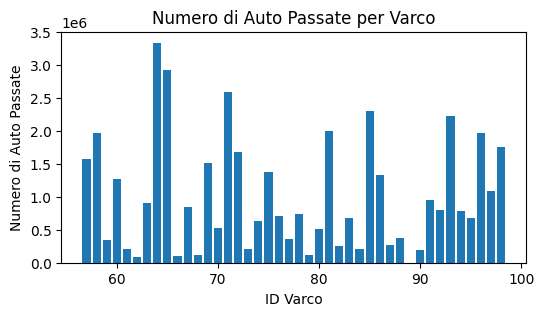

In [ ]:
#Istogramma
plt.figure(figsize=(6, 3))
plt.bar(auto_passate_per_varco.index, auto_passate_per_varco.values)
plt.xlabel('ID Varco')
plt.ylabel('Numero di Auto Passate')
plt.title('Numero di Auto Passate per Varco')
plt.show()
#observation: ID 89 we drop it (see above), ID 87 doesn't exist

Alcuni varchi vanno eliminati!! (no dati)


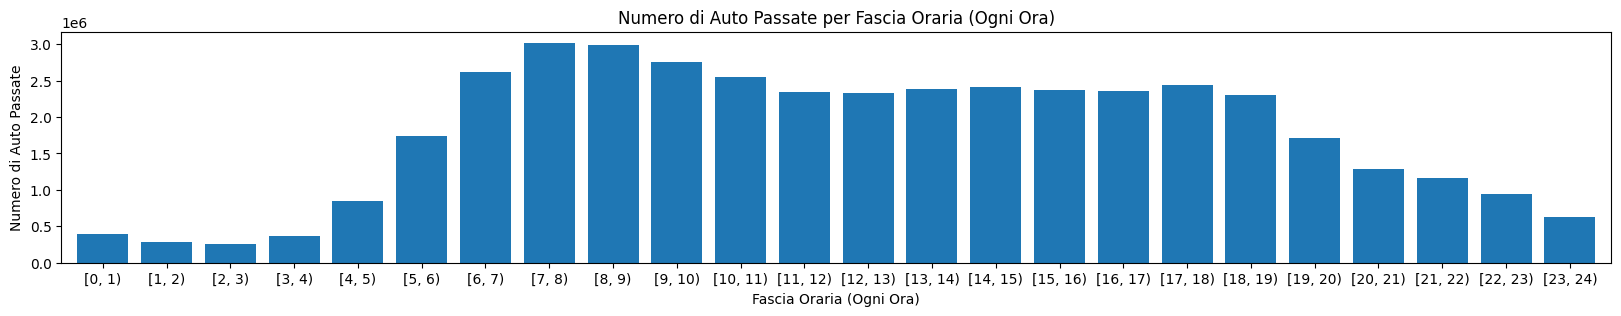

In [ ]:
#auto per fascia oraria
auto_per_fascia = df.groupby('fascia_oraria', observed=True)['numero_transiti'].sum()
plt.figure(figsize=(20, 3))
auto_per_fascia.plot(kind='bar', width=0.8)
plt.xlabel('Fascia Oraria (Ogni Ora)')
plt.ylabel('Numero di Auto Passate')
plt.title('Numero di Auto Passate per Fascia Oraria (Ogni Ora)')
plt.xticks(rotation=0)
plt.show()

#4 - New datasets: ingressi orari e ingressi giornalieri

In [ ]:
ingressi_giornalieri = df.groupby(['id_varco','data'])['numero_transiti'].sum().reset_index()
ingressi_orari = df.groupby(['id_varco','data','fascia_oraria'], observed = True)['numero_transiti'].sum().reset_index()

ingressi_giornalieri = ingressi_giornalieri[ingressi_giornalieri['id_varco'] != 87]
ingressi_orari = ingressi_orari[ingressi_orari['id_varco'] != 87]

In [ ]:
ingressi_giornalieri.head(3)

,id_varco,data,numero_transiti
0,57,2023-01-01,1598
1,57,2023-01-02,1999
2,57,2023-01-03,2439


In [ ]:
ingressi_orari.head(3)

,id_varco,data,fascia_oraria,numero_transiti
0,57,2022-01-01,"[0, 1)",69
1,57,2022-01-01,"[1, 2)",39
2,57,2022-01-01,"[2, 3)",30


#5 - Check missing data

(we fix the problem below)


In [ ]:
#conto ripetizioni della stessa ora su più righe
a = df.groupby(['data','fascia_oraria'], observed = True)['numero_transiti'].sum().reset_index()
a.rename(columns={'id_varco': 'n'}, inplace=True)

In [ ]:
a.tail(5)

,data,fascia_oraria,numero_transiti
8249,2022-12-24,"[18, 19)",4755
8250,2022-12-24,"[19, 20)",2924
8251,2022-12-24,"[20, 21)",1634
8252,2022-12-24,"[21, 22)",2393
8253,2022-12-24,"[22, 23)",3572


In [ ]:
ngg = a['data'].unique() #Numero di giorni nel dataset (mancano dei giorni):
# manca dal 20-06-22 al 25-06-22 e dal 13-09-22 al 18-09-22
# manca dal 19-02-23 al 24-02-23 (domenica-venerdì seconda/terza settimana) e dal 21-05-23 al 26-05-23 (dom-ven 3/4 sett)

ngg.shape #346 nel 2022, 261 nel 2023

(61,)

Dovrebbe venire 304 (numero di giorni dal primo dennaio al 31 ottobre 2023) ma nel dataset degli ingressi nell'area C mancano dei dati-> 20-06-22 al 25-06-22 e dal 13-09-22 al 18-09-22 e 19-02-23 al 24-02-23 (domenica-venerdì terza/quarta settimana) e dal 21-05-23 al 26-05-23 (dom-ven 3/4 sett)

In [ ]:
df = df[df['data'] >= datetime.strptime('2023-11-01', "%Y-%m-%d").date()]

In [ ]:
nontoc= df.copy()

**Carico dataset 2022**

In [ ]:
df2 = load_data(2023)
df2 = process_data(df2, 2023) # (nel 2022) qui manca dal 20-06-22 al 25-06-22 e dal 13-11-22 al 18-11-22 (al momento non ce ne frega)

/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_01.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_02.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_03.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_04.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_05.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_06.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_07.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_08.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_09.csv
/content/drive/MyDrive/Progetto/ingressi_orari/2023/ingressi_areac_2023_10.csv
(1302679, 13)


**Prendo dati dei giorni corrispondenti dal dataset 2022 e li metto in quello 2023**

In [ ]:
df = df[df['data'] <= datetime.strptime('2022-10-31', "%Y-%m-%d").date()]

In [ ]:
# mancava dal 19-02-23 al 24-02-23 (domenica-venerdì 3/4 settimana + 25 DATI SBAGLIATI) e dal 21-05-23 al 26-05-23 (dom-ven 3/4 sett + 27 DATI SBAGLIATI)
df_sub1 = df2[(df2['data'] <= datetime.strptime('2023-06-24', "%Y-%m-%d").date()) &
             (df2['data'] >= datetime.strptime('2023-06-19', "%Y-%m-%d").date())].copy()
df_sub1['data'] = df_sub1['data'] + pd.to_timedelta(1, unit='d')
df_sub1['data'] += pd.DateOffset(years=-1)
df_sub1['data'] = df_sub1['data'].apply(lambda x: x.date())


#df_sub2 = df2[(df2['data'] <= datetime.strptime('2023-10-17', "%Y-%m-%d").date()) &
#             (df2['data'] >= datetime.strptime('2023-10-12', "%Y-%m-%d").date())].copy()
#df_sub2['data'] = df_sub2['data'] + pd.to_timedelta(1, unit='d')
#df_sub2['data'] = df_sub2['data'] + pd.to_timedelta(1, unit='m')
#df_sub2['data'] += pd.DateOffset(years=-1)
#df_sub2['data'] = df_sub2['data'].apply(lambda x: x.date())

#del df2

In [ ]:
df['data'].unique().shape

(61,)

In [ ]:
df_sub1['data'].unique().shape

(6,)

In [ ]:
df_sub2['data'].unique().shape

(6,)

In [ ]:
# Tolgo righe problematica del dataset iniziale
#prova=df.copy()
#prova = prova[(prova['data'] != datetime.strptime('2022-02-25', "%Y-%m-%d").date()) &
             #(prova['data'] != datetime.strptime('2022-05-27', "%Y-%m-%d").date())]

KeyboardInterrupt: 

In [ ]:
ingressi_giornalieri.head(4)

,id_varco,data,numero_transiti
0,57,2022-01-01,1356
1,57,2022-01-02,1867
2,57,2022-01-03,2330
3,57,2022-01-04,2475


In [ ]:
ingressi_giornalieri.shape  # 13840 = 40 varchi x 346 giorni --> OK

(14697, 3)

In [ ]:
# Unisco i dataset da aggiungere
import pandas as pd
sub_gg = pd.concat([df, df_sub1], axis=0)
sub_gg = sub_gg.sort_values(by=['data','id_varco','ora']) # Riordina per data
sub_gg = sub_gg.reset_index(drop=True) # Reset indici righe
df = sub_gg.copy()
df['data'] = pd.to_datetime(df['data'])
#del df_sub1, df_sub2, sub_gg

In [ ]:
df['data'].unique().shape

(304,)

In [ ]:
ingressi_giornalieri = df.groupby(['id_varco','data'])['numero_transiti'].sum().reset_index()

In [ ]:
ingressi_giornalieri['data'].unique().shape

(61,)

In [ ]:
print(df['data'].unique().shape[0]) # ora 273: GIUSTO
valori_mancanti = df.isna().sum()

print("Valori mancanti in ogni colonna:")
print(valori_mancanti)
df.head(5)

304
Valori mancanti in ogni colonna:
id_varco                   0
esenti                     0
moto                       0
residenti                  0
veicoli_servizio           0
categoria_euro             0
tipologia_alimentazione    0
categoria_veicolo          0
classe_areac               0
fap                        0
areac                      0
numero_transiti            0
ora                        0
fascia_oraria              0
data                       0
dtype: int64


,id_varco,esenti,moto,residenti,veicoli_servizio,categoria_euro,tipologia_alimentazione,categoria_veicolo,classe_areac,fap,areac,numero_transiti,ora,fascia_oraria,data
0,57,0,0,0,0,1,0,4,5,0,0,2,00:00:00,"[0, 1)",2022-01-01
1,57,0,0,0,0,5,6,4,5,0,0,1,00:00:00,"[0, 1)",2022-01-01
2,57,0,0,0,0,6,1,4,5,0,0,1,00:00:00,"[0, 1)",2022-01-01
3,57,0,0,0,0,6,2,4,5,1,0,2,00:00:00,"[0, 1)",2022-01-01
4,57,0,0,0,0,7,1,4,5,0,0,5,00:00:00,"[0, 1)",2022-01-01


In [ ]:
df = df[df['id_varco'] != 87]
#df.to_csv('/content/drive/MyDrive/Progetto/ingressi_orari/dati/dati22.csv', index=False)

In [ ]:
df['id_varco'].unique()

array([57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
       74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 90, 91, 92,
       93, 94, 95, 96, 97, 98])

In [ ]:
ingressi_giornalieri = df.groupby(['id_varco','data'])['numero_transiti'].sum().reset_index()

In [ ]:
ingressi_giornalieri.shape

(12160, 3)

#6 - Area c ON vs Area C OFF



In [ ]:
df = load_data('dati22')

ValueError: No objects to concatenate

In [ ]:
df['id_varco'].unique()

array([57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
       74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91,
       92, 93, 94, 95, 96, 97, 98])

In [ ]:
df_on = df.groupby(['id_varco','data','areac'])['numero_transiti'].sum().reset_index()

In [ ]:
df[df['id_varco']==87]

,id_varco,esenti,moto,residenti,veicoli_servizio,categoria_euro,tipologia_alimentazione,categoria_veicolo,classe_areac,fap,areac,numero_transiti,ora,fascia_oraria,data
16679,87,0,0,0,0,0,0,0,0,0,0,12,00:00:00,"[0, 1)",2022-01-01
16680,87,0,0,0,0,0,0,0,0,0,0,13,00:30:00,"[0, 1)",2022-01-01
16681,87,0,0,0,0,0,0,0,0,0,0,10,01:00:00,"[1, 2)",2022-01-01
16682,87,0,0,0,0,0,0,0,0,0,0,7,01:30:00,"[1, 2)",2022-01-01
16683,87,0,0,0,0,0,0,0,0,0,0,8,02:00:00,"[2, 3)",2022-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5949610,87,0,0,0,0,0,0,0,0,0,0,35,19:30:00,"[19, 20)",2022-05-29
5949611,87,0,0,0,0,0,0,0,0,0,0,33,20:00:00,"[20, 21)",2022-05-29
5949612,87,0,0,0,0,0,0,0,0,0,0,33,20:30:00,"[20, 21)",2022-05-29
5949613,87,0,0,0,0,0,0,0,0,0,0,30,21:00:00,"[21, 22)",2022-05-29


In [ ]:
type(df['fascia_oraria'].iloc[0])

pandas._libs.interval.Interval

In [ ]:
# Fix dei giorni in cui c'è solo areac = 0 oppure areac = 1 ma non entrambi
new_rows = []
data_idx = df_on.columns.get_loc('data22')

for varco in df_on['id_varco'].unique():
    for day in df_on['data'].unique():
        subset = df_on[(df_on['id_varco'] == varco) & (df_on['data'] == day)]
        subset_length = subset.shape[0]

        if subset_length == 1:
            new_row = {
                'id_varco': varco,
                'data': day,
                'areac': 1 - subset['areac'].iloc[0],
                'numero_transiti': 0
            }
            new_rows.append(subset.iloc[0].to_dict())
            new_rows.append(new_row)
        elif subset_length >= 2:
            new_rows.append(subset.iloc[0].to_dict())
            new_rows.append(subset.iloc[1].to_dict())

new_df = pd.DataFrame(new_rows)

KeyError: 'data22'

In [ ]:
new_df.head(4)

,id_varco,data,areac,numero_transiti
0,57,2023-01-01,0,1598
1,57,2023-01-01,1,0
2,57,2023-01-02,0,561
3,57,2023-01-02,1,1438


In [ ]:
# Creazione di una colonna 'ingressi_areac' per consentire la differenziazione tra 0 e 1
df_copia = df.copy()
df['ingressi_areac'] = 'ingressi_areac_' + df['areac'].astype(str)

# Creazione della tabella pivot
pivot_df = df.pivot_table(index=['id_varco', 'data'], columns='ingressi_areac', values='numero_transiti', aggfunc='sum').reset_index()

# Rinomina delle colonne per una migliore chiarezza
pivot_df.columns.name = None  # Rimuove il nome della colonna dall'intestazione
pivot_df = pivot_df.rename(columns={'ingressi_areac_0': 'ingressi_areac_0', 'ingressi_areac_1': 'ingressi_areac_1'})


In [ ]:
pivot_df.fillna(0, inplace=True)
columns_to_convert = ['ingressi_areac_0', 'ingressi_areac_1']
# Conversione delle colonne specificate in interi
pivot_df[columns_to_convert] = pivot_df[columns_to_convert].astype(int)
pivot_df['ingressi_tot'] = pivot_df['ingressi_areac_0'] + pivot_df['ingressi_areac_1']

In [ ]:
df = df_copia.copy()
del df_copia, df_on

In [ ]:
pivot_df.head(5)

,id_varco,data,ingressi_areac_0,ingressi_areac_1,ingressi_tot
0,57,2023-01-01,1598,0,1598
1,57,2023-01-02,561,1438,1999
2,57,2023-01-03,688,1751,2439
3,57,2023-01-04,756,1916,2672
4,57,2023-01-05,873,2179,3052


#8 - New complete datasets

In [ ]:
# Aggiungo differenziazione ingressi
ig = df.groupby(['id_varco','data'])['numero_transiti'].sum().reset_index()
ig['ingressi_areac_1'] = pivot_df['ingressi_areac_1']
ig['ingressi_areac_0'] = pivot_df['ingressi_areac_0']
#del pivot_df

KeyboardInterrupt: 

In [ ]:
# Aggiungo giorni della settimana
ig['giorno'] = ig['data'].apply(lambda x: calendar.day_name[x.weekday()])

# Aggiungo festivi
ig['festivo'] = 0
ig.loc[(ig['giorno'] == 'Sunday') | (ig['giorno'] == 'Saturday'), 'festivo'] = 1
ig.loc[ig['data'] == datetime.strptime('2023-01-01', "%Y-%m-%d").date(), 'festivo'] = 1
ig.loc[ig['data'] == datetime.strptime('2023-01-06', "%Y-%m-%d").date(), 'festivo'] = 1
ig.loc[ig['data'] == datetime.strptime('2023-04-09', "%Y-%m-%d").date(), 'festivo'] = 1
ig.loc[ig['data'] == datetime.strptime('2023-04-11', "%Y-%m-%d").date(), 'festivo'] = 1
ig.loc[ig['data'] == datetime.strptime('2023-04-25', "%Y-%m-%d").date(), 'festivo'] = 1
ig.loc[ig['data'] == datetime.strptime('2023-05-01', "%Y-%m-%d").date(), 'festivo'] = 1
ig.loc[ig['data'] == datetime.strptime('2023-06-02', "%Y-%m-%d").date(), 'festivo'] = 1
ig.loc[ig['data'] == datetime.strptime('2023-08-15', "%Y-%m-%d").date(), 'festivo'] = 1
# prox data: 1 novembre

In [ ]:
df_varchi = pd.read_csv('/content/drive/MyDrive/Progetto/ingressi_areac_varchi.csv', delimiter=';')

# Unisci le informazioni delle coordinate
ig = pd.merge(ig, df_varchi[['id_amat', 'LONG_X_4326', 'LAT_Y_4326', 'Location', 'label']], left_on='id_varco', right_on='id_amat', how='left')

# Rinomina le colonne
ig = ig.rename(columns={'LONG_X_4326': 'longitude', 'LAT_Y_4326': 'latitude', 'label': 'nome_varco'})

# Rimuovi le colonne aggiuntive
ig.drop('id_amat', axis=1, inplace=True)


In [ ]:
ig.tail(4)

In [ ]:
ig['id_varco'].unique()

In [ ]:
av = ig.groupby(['id_varco'])['numero_transiti'].mean().reset_index()
av = av.sort_values(by=['numero_transiti']) # Riordina

**grafico orario settimanale**

In [ ]:
df_mezz = load_data('dati')

In [ ]:
df_mezz.head(4)

In [ ]:
# Runna questo al posto del blocco sotto per avere ogni mezz'ora
#ingressi_hh = df_mezz.groupby(['id_varco','data','ora'])['numero_transiti'].sum().reset_index()

In [ ]:
ingressi_hh = df_mezz.groupby(['id_varco','data','fascia_oraria'])['numero_transiti'].sum().reset_index()
ordine_fasce = {
    '[0, 1)': 1,
    '[1, 2)': 2,
    '[2, 3)': 3,
    '[3, 4)': 4,
    '[4, 5)': 5,
    '[5, 6)': 6,
    '[6, 7)': 7,
    '[7, 8)': 7,
    '[8, 9)': 8,
    '[9, 10)': 9,
    '[10, 11)': 10,
    '[11, 12)': 11,
    '[12, 13)': 12,
    '[13, 14)': 13,
    '[14, 15)': 14,
    '[15, 16)': 15,
    '[16, 17)': 16,
    '[17, 18)': 17,
    '[18, 19)': 18,
    '[19, 20)': 19,
    '[20, 21)': 20,
    '[21, 22)': 21,
    '[22, 23)': 22,
    '[23, 24)': 23,
}

# Aggiunta di una colonna temporanea contenente l'ordine personalizzato delle fasce di dati
ingressi_hh['ordine_fasce'] = ingressi_hh['fascia_oraria'].map(ordine_fasce)

# Ordinamento del DataFrame in base alla nuova colonna di ordine personalizzato
ingressi_hh = ingressi_hh.sort_values(by=['data', 'id_varco', 'ordine_fasce'])

# Eliminazione della colonna temporanea aggiunta
ingressi_hh = ingressi_hh.drop('ordine_fasce', axis=1)

In [ ]:
ingressi_hh['giorno'] = ingressi_hh['data'].apply(lambda x: calendar.day_name[x.weekday()])
ingressi_hh.head(4)

In [ ]:
ingressi_hh.tail(4)

In [ ]:
type(ingressi_hh['fascia_oraria'].iloc[0])

In [ ]:
# scelgo i varchi che voglio
ingressi_hh = ingressi_hh[ingressi_hh['id_varco'].isin([85])]
quanti_giorni = 14
plot_orari('2023-03-06', quanti_giorni, 'numero_transiti', ingressi_hh)

#9 - Some plots

**Plot ingressi giornalieri per tutto l'anno**

In [ ]:
#ig = data_stan.copy()

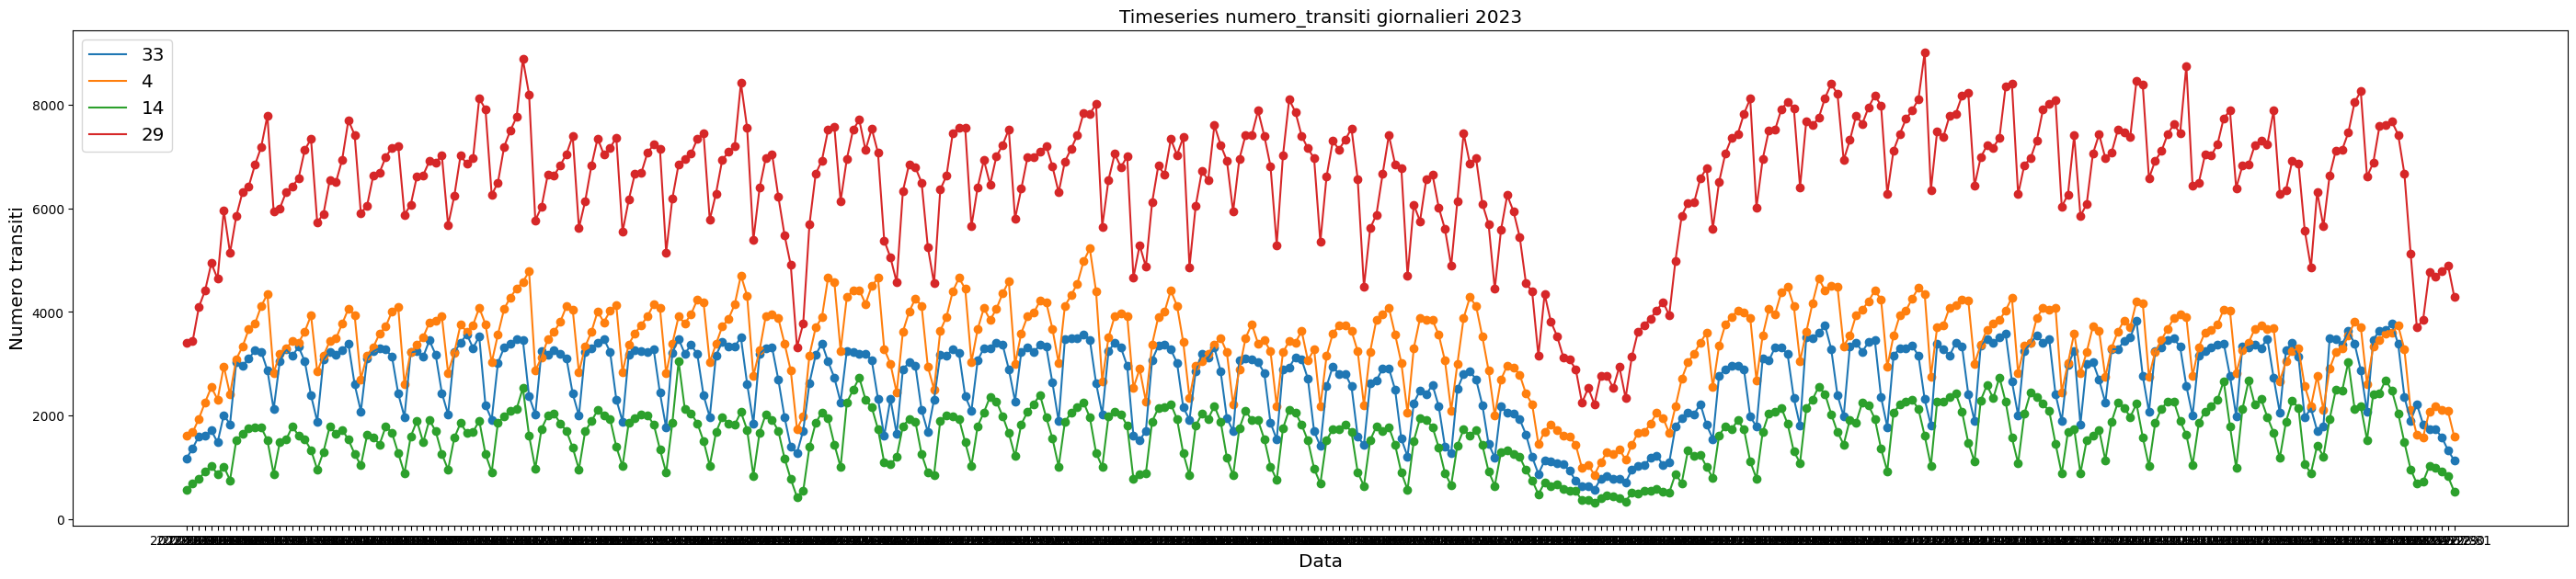

In [ ]:
plot_data_by_varco(ig, [33, 4, 14, 29], 'numero_transiti')
#plt.savefig('/content/drive/MyDrive/Progetto/plot_report/timeser-annuale.png', bbox_inches='tight')

SETTIMANALI

In [ ]:
# Scelgo due settimane a caso
ig1 = ig[ig['data']>= datetime.strptime('2023-03-06', "%Y-%m-%d").date()]
ig1 = ig1[ig1['data']<= datetime.strptime('2023-03-20', "%Y-%m-%d").date()]

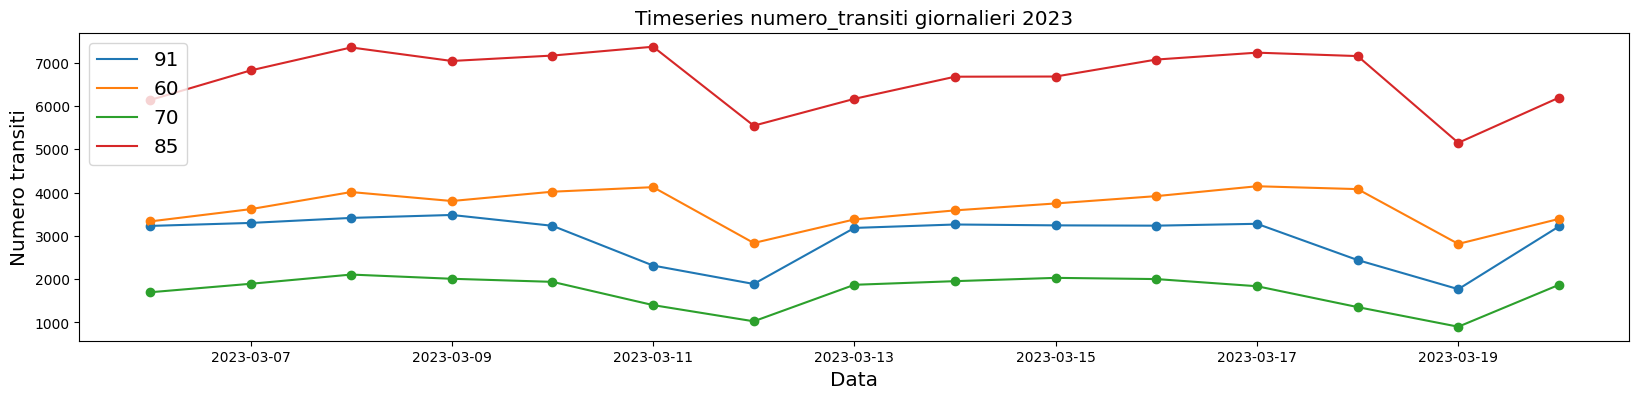

In [ ]:
plot_data_by_varco(ig1, [91, 60, 70, 85], 'numero_transiti')

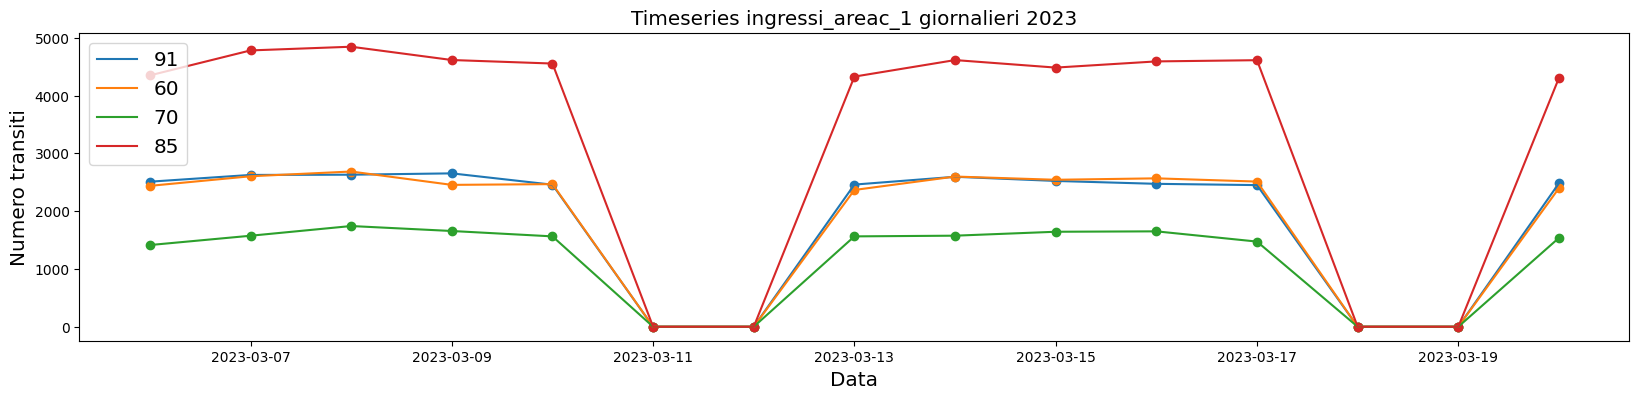

In [ ]:
plot_data_by_varco(ig1, [91, 60, 70, 85], 'ingressi_areac_1')
#plt.savefig('/content/drive/MyDrive/Progetto/ingressi_orari/due_sett_areac_ON.png')

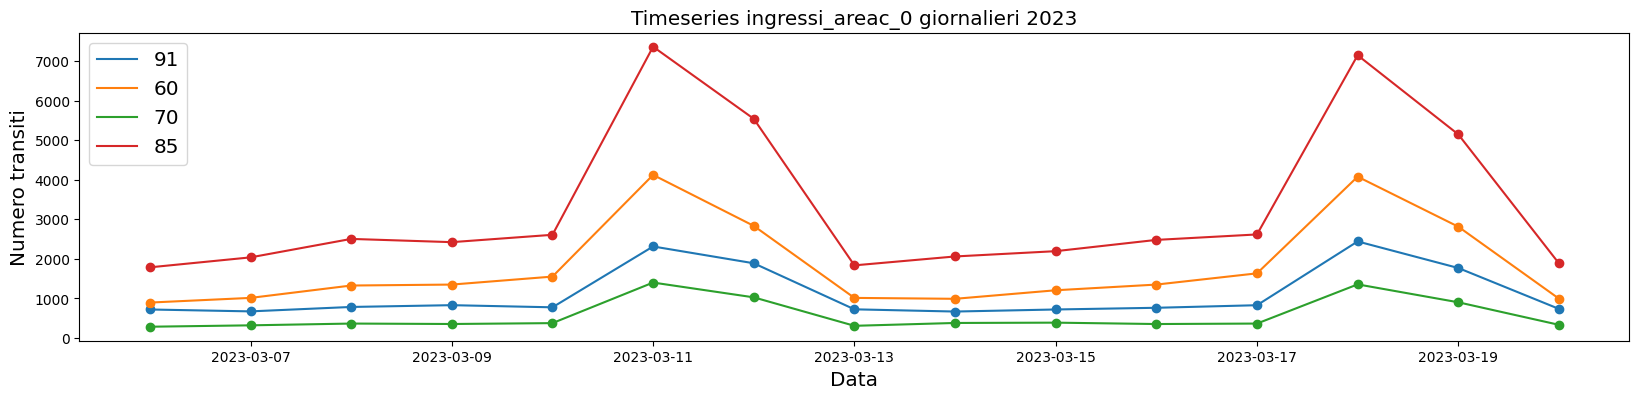

In [ ]:
plot_data_by_varco(ig1, [91, 60, 70, 85], 'ingressi_areac_0')
#plt.savefig('/content/drive/MyDrive/Progetto/ingressi_orari/due_sett_areac_OFF.png', bbox_inches='tight')

#10 - New Weather observations dataset

In [ ]:
# Dataset Arpa Lombardia con precipitazioni in via Brera nel 2023
pioggia_df = pd.read_csv("/content/drive/MyDrive/Progetto/meteo_2023/pio.csv", delimiter=',') # oppure meteo_2022 e pioggia22
temp_df = pd.read_csv("/content/drive/MyDrive/Progetto/meteo_2023/temp.csv", delimiter=',')

pioggia_df.rename(columns={'Valore Cumulata Giornaliero': 'Valore'}, inplace=True)
temp_df.rename(columns={'Valore Medio Giornaliero': 'Valore'}, inplace=True)

In [ ]:
meteo.head(3)

,data,precipitazioni,temp
0,2023-01-01,3.6,8.4
1,2023-01-02,2.6,9.5
2,2023-01-03,7.6,10.0


In [ ]:
meteo['Data-Ora']= pd.to_datetime(meteo['Data-Ora'])

<ipython-input-76-ac2912e16639>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo['Data-Ora']= pd.to_datetime(meteo['Data-Ora'])


**Sistemo e unisco i dataset**

In [ ]:
last = str(data_stan["data"].iloc[-1])
print("Dataset aggiornato al: " + last) # Ultima data disponibile nel dataset ingressi area C
pioggia = process_meteo(pioggia_df,'2023-01-01',last)  # formato %Y-%m-%d
temp = process_meteo(temp_df,'2023-01-01',last)

# Unisco tutto in un unico dataset: meteo
pioggia.rename(columns={'Valore': 'precipitazioni'}, inplace=True)
pioggia['temp'] = temp['Valore']
meteo = pioggia.copy()
del pioggia

meteo_hh = fixvalues_back(meteo)

Dataset aggiornato al: 2023-12-31


<ipython-input-78-0c7769725254>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo['data'] = pd.to_datetime(meteo['data'])
<ipython-input-78-0c7769725254>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo['data'] = meteo['data'].dt.date
<ipython-input-78-0c7769725254>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [ ]:
pioggia_df.head(5)

,Id Sensore,Data-Ora,Valore,Minimo Valore Cumulata Orario,Massimo Valore Cumulata Orario,data
0,19373,2023/01/01,3.6,0.0,0.4,2023-01-01
1,19373,2023/01/02,2.6,0.0,0.4,2023-01-02
2,19373,2023/01/03,7.6,0.0,1.0,2023-01-03
3,19373,2023/01/04,0.0,0.0,0.0,2023-01-04
4,19373,2023/01/05,0.0,0.0,0.0,2023-01-05


**Raggruppo giornalmente**

In [ ]:
meteo_gg = meteo_hh.copy()
meteo_gg = meteo_gg.groupby('data')['precipitazioni'].sum().reset_index()
newcol = meteo_hh.groupby('data')['temp'].mean().reset_index()
meteo_gg['av_temp'] = newcol['temp']
del newcol

In [ ]:
meteo_gg.tail(4)

,data,precipitazioni,av_temp
312,2023-11-09,6.4,10.4
313,2023-11-10,0.0,NaN
314,2023-11-11,0.0,NaN
315,2023-11-12,0.0,NaN


In [ ]:
meteo_gg = meteo_gg[meteo_gg['data']>= datetime.strptime('2023-11-01', "%Y-%m-%d").date()]

#11 - Weather Charts


**Grafico precipitazioni giornaliere anno 202**3

In [ ]:
meteo_hh.head(4)

,data,ora,precipitazioni,temp
0,2023-01-01,00:00,0.4,8.1
1,2023-01-01,01:00,0.2,8.3
2,2023-01-01,02:00,0.0,8.4
3,2023-01-01,03:00,0.4,8.2


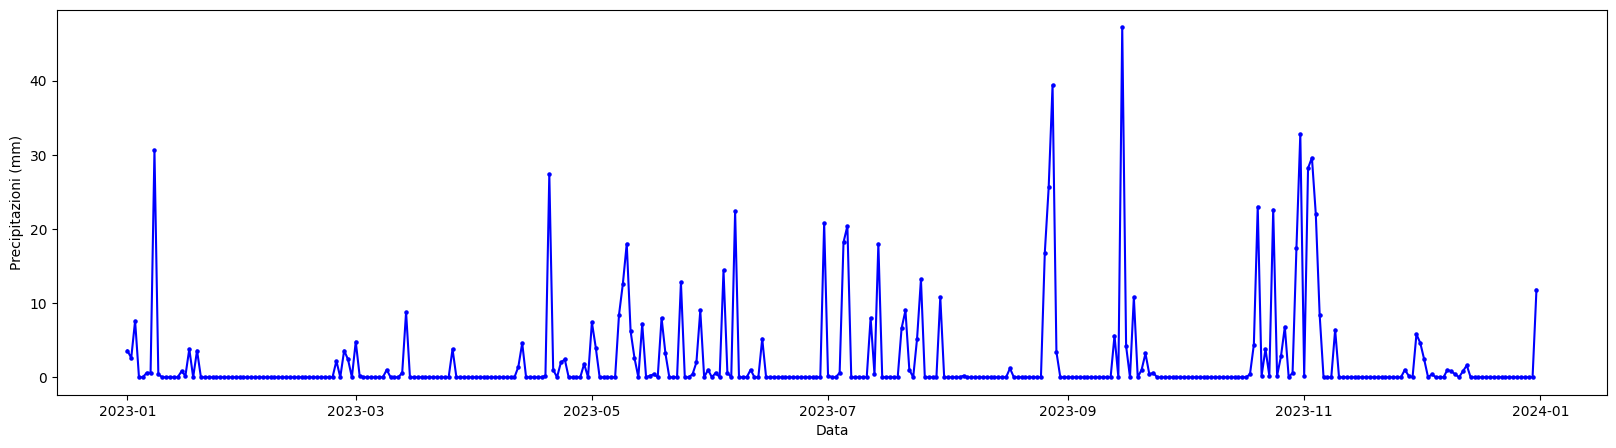

In [ ]:
# Grafico pioggia anno 2023
plt.figure(figsize=(20, 5))
plt.scatter(meteo_gg.data, meteo_gg.precipitazioni, s=5, marker='o', color='b')
plt.plot(meteo_gg.data.to_numpy(), meteo_gg.precipitazioni.to_numpy(), linestyle='-', color='b')
plt.xlabel('Data')
plt.ylabel('Precipitazioni (mm)')
plt.savefig('/content/drive/MyDrive/Progetto/plot_report/pioggia-annuale.png', bbox_inches='tight')
plt.show()

Magari inserire una o più threshold e rendere la variabile pioggia categorica

**Grafico temperatura media giornaliera anno 2023**

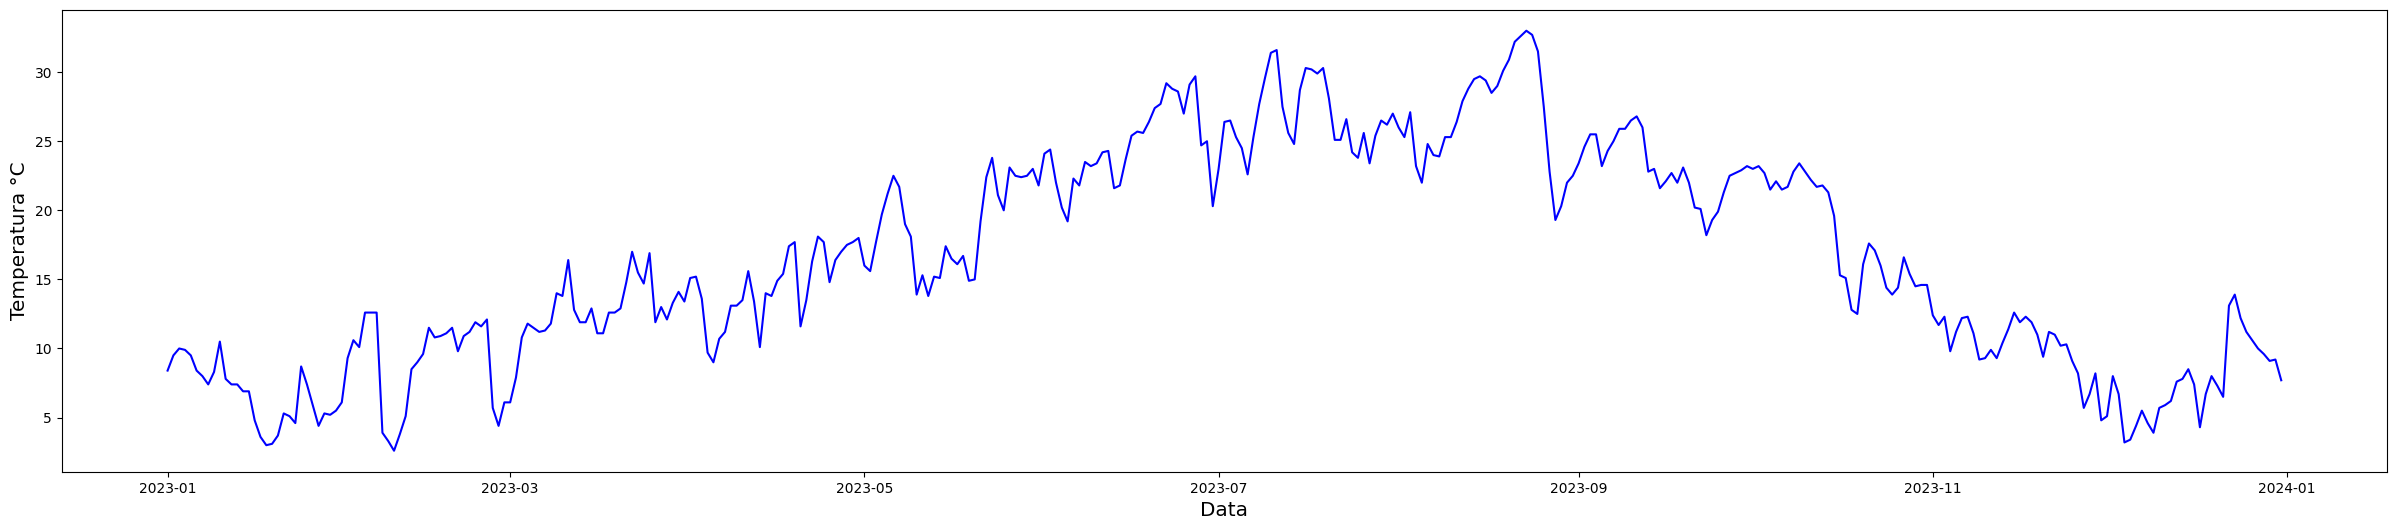

In [ ]:
plt.figure(figsize=(30, 6))
plt.plot(meteo_gg.data.to_numpy(), meteo_gg.av_temp.to_numpy(), linestyle='-', color='b')
plt.xlabel('Data', fontsize = 'x-large')
plt.ylabel('Temperatura °C', fontsize = 'x-large')
plt.savefig('/content/drive/MyDrive/Progetto/plot_report/temp-annuale.png', bbox_inches='tight')
plt.show()

**Grafico temperatura 2 settimane a caso del 2023**

In [ ]:
meteo_hh.head(4)

,data,ora,precipitazioni,temp
0,2023-01-01,00:00,0.4,8.1
1,2023-01-01,01:00,0.2,8.3
2,2023-01-01,02:00,0.0,8.4
3,2023-01-01,03:00,0.4,8.2


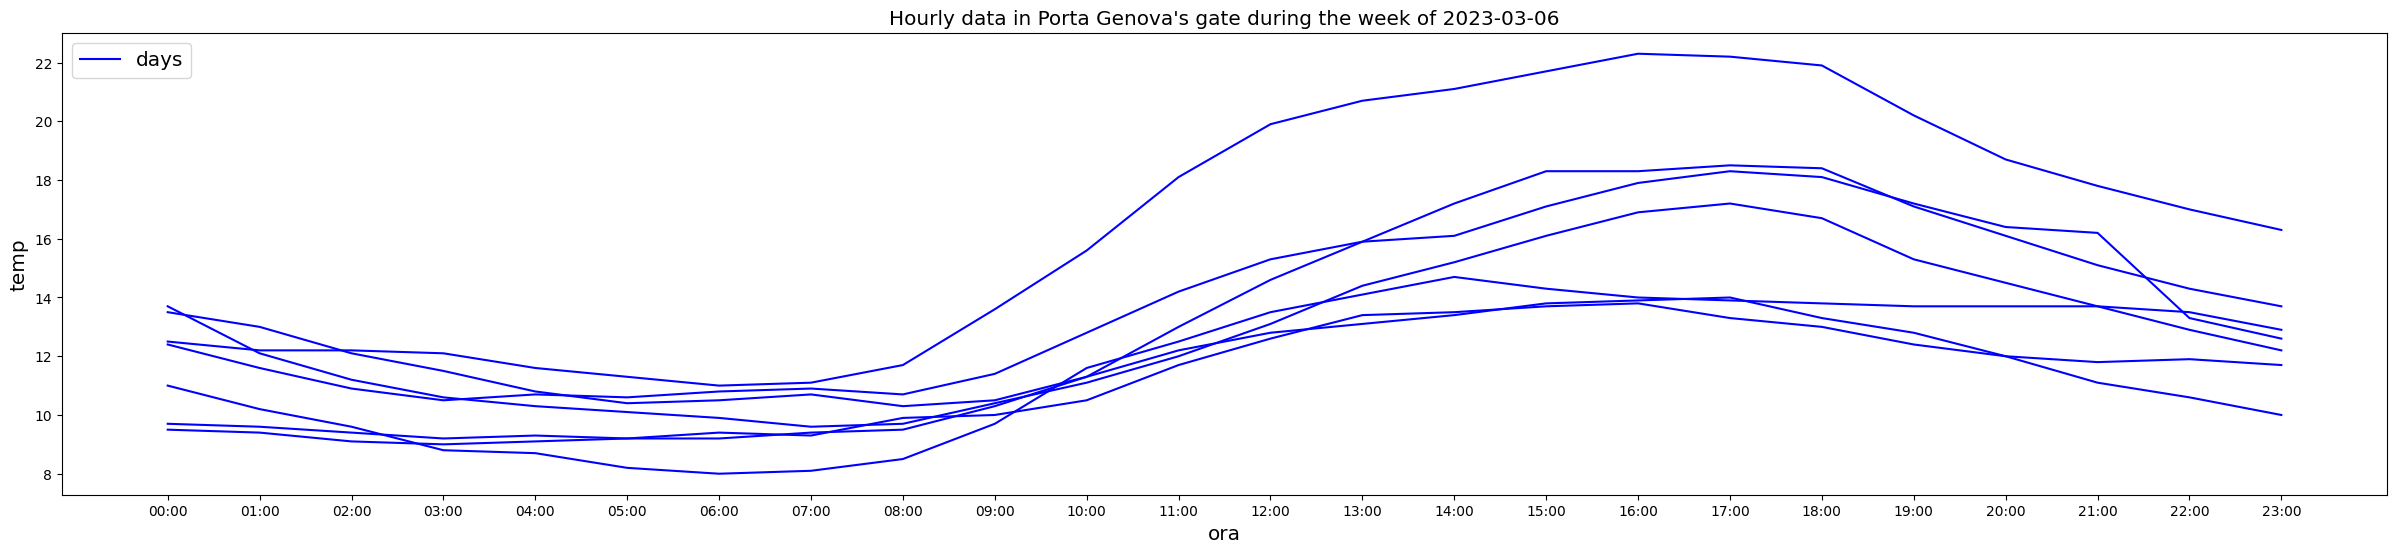

In [ ]:
quanti_giorni = 7
plot_orari('2023-03-06', quanti_giorni, 'temp', meteo_hh)

In [ ]:
df.head(4)

,id_varco,esenti,moto,residenti,veicoli_servizio,categoria_euro,tipologia_alimentazione,categoria_veicolo,classe_areac,fap,areac,numero_transiti,ora,fascia_oraria,data
0,57,0,0,0,0,0,0,0,5,0,0,3,00:00:00,"[0, 1)",2023-01-01
1,57,0,0,0,0,0,3,4,2,0,0,1,00:00:00,"[0, 1)",2023-01-01
2,57,0,0,0,0,5,1,4,5,0,0,3,00:00:00,"[0, 1)",2023-01-01
3,57,0,0,0,0,5,6,4,5,0,0,1,00:00:00,"[0, 1)",2023-01-01


#12 - Data preparation for STAN 2023 (whole year)

In [ ]:
stan=data_stan.copy()

In [ ]:
data_stan = ingressi_giornalieri

In [ ]:
meteo_gg.shape

(12, 3)

In [ ]:
data_stan['precipitazioni'] = meteo_gg['precipitazioni']
data_stan['av_temp'] = meteo_gg['av_temp']

In [ ]:
data_stan.tail(4)

,id_varco,data,numero_transiti,nord,sud,est,ovest,estate,inverno
2436,40,2023-12-28,3823,0,0,0,1,0,1
2437,40,2023-12-29,3671,0,0,0,1,0,1
2438,40,2023-12-30,3358,0,0,0,1,0,1
2439,40,2023-12-31,2653,0,0,0,1,0,1


In [ ]:
# scelgo le colonne
data_stan = ig.copy()
data_stan.drop(['ingressi_areac_1','ingressi_areac_0', 'Location'],axis='columns', inplace = True)
data_stan = data_stan[data_stan['id_varco'] != 87]

In [ ]:
# Rimappo i varchi da 1 a 40 se no stan si arrabbia
i = 1
for t in range(57,99):
    if t == 89:
      t = t+1
    if t == 87:
      t = t+1
    mask = data_stan['id_varco'] == t
    data_stan.loc[mask, 'id_varco'] = i
    if data_stan[mask].shape[0] > 0:
        i += 1

In [ ]:
data_stan.shape # 304 gg x 40 varchi

(2440, 3)

In [ ]:
data_stan = pd.merge(data_stan, meteo_gg, on='data', how='inner')

In [ ]:
#Categorizzo zone
data_stan['nord'] = 0
data_stan['sud'] = 0
data_stan['est'] = 0
data_stan['ovest'] = 0
data_stan['estate'] = 0
data_stan['inverno'] = 0


data_stan.loc[data_stan['id_varco'].isin([1, 2, 3, 4, 5, 6, 7, 8]), 'nord'] = 1
data_stan.loc[data_stan['id_varco'].isin([9,10, 11, 12, 13, 14, 15, 16, 17, 18]), 'est'] = 1
data_stan.loc[data_stan['id_varco'].isin([19,20, 21, 22, 23, 24, 25, 26, 27, 28]), 'sud'] = 1
data_stan.loc[data_stan['id_varco'].isin([29,30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]), 'ovest'] = 1
data_stan.loc[(data_stan['data'] >= to_data('2023-05-01')) & (data_stan['data'] <= to_data('2023-08-31')),'estate'] = 1
data_stan.loc[(data_stan['data'] >= to_data('2023-01-01')) & (data_stan['data'] <= to_data('2023-02-28')),'inverno'] = 1
data_stan.loc[(data_stan['data'] >= to_data('2023-12-01')) & (data_stan['data'] <= to_data('2023-12-31')),'inverno'] = 1

In [ ]:
data_fin.to_csv('/content/drive/MyDrive/Progetto/ingressi_orari/stan/data_stan_completo.csv', index=False)

#12.5 - Data preparation for CAR 2022

In [ ]:
data_car = ingressi_giornalieri.copy()

In [ ]:
data_car.head(4)

,id_varco,data,numero_transiti
0,1,2022-01-01,1356
1,1,2022-01-02,1867
2,1,2022-01-03,2330
3,1,2022-01-04,2475


In [ ]:
data_car['id_varco'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40])

In [ ]:
data_car.shape

(12160, 3)

In [ ]:
# Rimappo i varchi da 1 a 40 se no stan si arrabbia
i = 1
for t in range(57,99):
    if t == 89:
      t = t+1
    if t == 87:
      t = t+1
    mask = data_car['id_varco'] == t
    data_car.loc[mask, 'id_varco'] = i
    if data_car[mask].shape[0] > 0:
        i += 1

In [ ]:
data_car.to_csv('/content/drive/MyDrive/Progetto/ingressi_orari/stan/data_CAR22.csv', index=False)

# 13-STAN Install

In [13]:
!pip install git+https://github.com/OriolAbril/arviz.git@ci

  Cloning https://github.com/OriolAbril/arviz.git (to revision ci) to /tmp/pip-req-build-wphf0q7r
  Running command git clone --filter=blob:none --quiet https://github.com/OriolAbril/arviz.git /tmp/pip-req-build-wphf0q7r
  Running command git checkout -b ci --track origin/ci
  Switched to a new branch 'ci'
  Branch 'ci' set up to track remote branch 'ci' from 'origin'.
  Resolved https://github.com/OriolAbril/arviz.git to commit 7c20182c25b0b5e9af8242d1ee4d1185ae82b70a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for arviz: filename=arviz-0.17.0.dev0-py3-none-any.whl size=1651459 sha256=aa62d30f4b4e61c0d5695720b661a924a12ceecdda1b96a64716382a801458bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-2k2v58hc/wheels/46/1e/6c/46b9c646a79d4a0f01b37df1c2c0abcc4e7129fe66e88e9b0f
Successfully built arviz
  Attempting uninstall: arviz
    Found existing installation: arviz 0.15.1
    Unin

In [14]:
# Install cmdstan
from cmdstanpy import install_cmdstan
install_cmdstan(compiler = True)

CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.34.1
Download successful, file: /tmp/tmpuiu9q2u9
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.34.1
Building version cmdstan-2.34.1, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.34.1
Test model compilation


True

In [15]:
import arviz as az
# Import functions
from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
from cmdstanpy import CmdStanModel

# 14 -The STAN Model

**BETA[1,4]**

In [17]:
data_stan = pd.read_csv('/content/drive/MyDrive/Progetto/ingressi_orari/stan/data_stan_completo.csv', delimiter=',')

In [ ]:
data_stan.tail(5)

,id_varco,data,numero_transiti,giorno,festivo,longitude,latitude,nome_varco,precipitazioni,av_temp,nord,sud,est,ovest,estate,inverno
14595,36,2023-12-31,953,Sunday,1,9.166858,45.467772,XX SETTEMBRE,11.8,7.7,0,0,0,1,0,1
14596,37,2023-12-31,1180,Sunday,1,9.166435,45.467898,BAZZONI,11.8,7.7,0,0,0,1,0,1
14597,38,2023-12-31,3246,Sunday,1,9.166059,45.469424,MASCHERONI,11.8,7.7,0,0,0,1,0,1
14598,39,2023-12-31,1209,Sunday,1,9.169088,45.470916,MONTI,11.8,7.7,0,0,0,1,0,1
14599,40,2023-12-31,2653,Sunday,1,9.170103,45.473807,MILTON,11.8,7.7,0,0,0,1,0,1


In [19]:
data_stan['mezzi'] = 0
data_stan.loc[data_stan['id_varco'] == 17, 'mezzi'] = 1
data_stan.loc[data_stan['id_varco'] == 21, 'mezzi'] = 1
data_stan.loc[data_stan['id_varco'] == 24, 'mezzi'] = 1
data_stan.loc[data_stan['id_varco'] == 26, 'mezzi'] = 1
data_stan.loc[data_stan['id_varco'] == 34, 'mezzi'] = 1

In [ ]:
coeff

array([0.03068713, 0.03879967, 0.00663409, 0.02503727, 0.00407707,
       0.00162911, 0.01768714, 0.06515276, 0.05716541, 0.00199831,
       0.01634718, 0.00230347, 0.02943237, 0.01022054, 0.05068277,
       0.03294929, 0.00409701, 0.01221306, 0.02699992, 0.01365506,
       0.00700272, 0.01445089, 0.00233951, 0.00995779, 0.03925766,
       0.00502495, 0.01332181, 0.0040912 , 0.04516437, 0.02594406,
       0.00745688, 0.00393163, 0.01840609, 0.01569823, 0.04333   ,
       0.01536706, 0.01330913, 0.03862846, 0.02088554, 0.0344184 ])

In [ ]:
coeff

array([0.03716251, 0.0469869 , 0.00803397, 0.03032046, 0.00493738,
       0.00197287, 0.02141936, 0.07890084, 0.06922806, 0.00241998,
       0.01979665, 0.00278953, 0.03564298, 0.0123772 , 0.06137749,
       0.03990202, 0.00496153, 0.01479018, 0.03269726, 0.01653646,
       0.00848038, 0.01750021, 0.00283318, 0.01205901, 0.04754153,
       0.00608528, 0.01613288, 0.00495449, 0.05469464, 0.03141859,
       0.00903037, 0.00476126, 0.02229002, 0.01901076, 0.05247319,
       0.0186097 , 0.01611753, 0.04677957, 0.02529266, 0.04168113])

In [20]:

data_stan['precipitazioni'] = (data_stan['precipitazioni'] - data_stan['precipitazioni'].mean()) / data_stan['precipitazioni'].std()
data_stan['av_temp'] = (data_stan['av_temp'] - data_stan['av_temp'].mean()) / data_stan['av_temp'].std()


In [21]:
n_varchi = data_stan['id_varco'].unique()
I = len(n_varchi)
coeff = np.zeros(I) # vettore di 40 elementi
data_coeff = pd.read_csv('/content/drive/MyDrive/Progetto/ingressi_orari/stan/data_CAR22.csv', delimiter=',')
for i in range(I):
  coeff[i] = data_coeff[data_coeff['id_varco']==i+1]['numero_transiti'].sum()/data_coeff['numero_transiti'].sum()
del data_coeff

In [22]:
# Costanti da passare a stan
I = len(data_stan['id_varco'].unique())
T = len(data_stan['data'].unique())

# Creo vettore output che mi serve per il modello stan
output = np.zeros((len(data_stan['id_varco'].unique()),len(data_stan['data'].unique())), dtype=int)
output = [row[:] for row in output]

# Altre robe da inizializzare per stan
time = [datetime.strptime(d, "%Y-%m-%d").timetuple().tm_yday for d in data_stan['data']] # mappo i giorni da 1 a n_giorni disponibili
time_matrix = np.reshape(time, (I, T), order='F')
lambda_matrix = np.zeros((I, T))
output_flat = np.zeros(I*T, dtype=int)

coeff_c_i = pd.read_csv('/content/drive/MyDrive/Progetto/c_i.csv')
media = coeff_c_i['c_i.poi3']

In [ ]:
# Dati di esempio: numero di eventi in diverse aree geografiche e tempi
data = {
    'N': data_stan.shape[0],  # Numero totale di osservazioni (spaziali-temporali)
    'T': len(data_stan['data'].unique()),  # Numero di periodi temporali unici (304)
    'I': len(data_stan['id_varco'].unique()),  # Numero di aree geografiche (40)
    'count': data_stan.groupby(['id_varco', 'data'])['numero_transiti'].sum().unstack().values.tolist(),    # Conteggi degli ingressi
    'time': time_matrix,  # Giorno dell'anno dalle date (la formula strana serve per avere valori da 1 a 304)
    'area': data_stan['id_varco'].values,        # Identificatori delle aree geografiche
    'precipitazioni': data_stan['precipitazioni'].values,    # Precipitazioni
    'av_temp': data_stan['av_temp'].values,              # Temperatura media
    'Xt': data_stan[['data', 'precipitazioni','av_temp','estate','inverno']].drop_duplicates().reset_index()[['precipitazioni', 'av_temp','estate','inverno']].transpose(),     #data_stan[['precipitazioni','av_temp']].values.transpose(),
    'Xi': data_stan[['nome_varco','mezzi']].drop_duplicates().reset_index()[['mezzi']].transpose(),
    #'sc': covariance_matrix,     # mettere qua la matrice varianza e covarianza calcolata fuori da stan
    'fixed_w1':  2*math.pi/7,
    'fixed_w2': 2*math.pi/226,  #226 = numero giorni da 1 gennaio a 15 agosto
    'output': output,
    'mu_c': media,
    'output_flat': np.zeros(I*T, dtype=int),
    'coeff': coeff
}

# Definizione del modello in Stan
stan_code = """
functions {
  // Definizione della funzione f(t)
  matrix f_matr(real a, real b, real c, real d, real w1, real w2, matrix t) {
    return a*sin(w1 * t) + b*cos(w1 * t) + c*sin(w2 * t) + d*cos(w2 * t);
  }





  matrix f_ma(real a, real b, real w, matrix A){
    int rows = rows(A);
    int cols = cols(A);
    matrix[rows, cols] result;

    for (i in 1:rows) {
      for (j in 1:cols) {
        result[i, j] = a * sin(w * A[i, j]) + b * cos(w * A[i, j]);
      }
    }
    return result;
  }


}


data {   //30
    int<lower=0> N;                       // Numero totale di osservazioni
    int<lower=0> T;                       // Numero di periodi temporali distinti   20
    int<lower=0> I;                       // Numero di aree geografiche distinti
    array[I,T] real count;             // Conteggi degli eventi
    matrix[I,T] time;        // Periodi temporali
    array[N] real area;        // Identificatori delle aree geografiche
    array[N] real precipitazioni;               // Precipitazioni
    array[N] real av_temp;                      // Temperatura media
    matrix[4,T] Xt;
    matrix[1,I] Xi;
    row_vector[I] mu_c;
    row_vector[I] coeff;
    array[I * T] int<lower=0> output_flat;
    array[I,T] int<lower=0>  output;
    real fixed_w1;                    // Valore fisso per w
    real fixed_w2;

} //51

parameters {

    row_vector[I] c;
    //row_vector[I] a;
    real a0;
    real b0;
    real a1;
    real b1;
    row_vector[4] beta;                    // Coefficienti per Xt
    //matrix[I, 4] beta;

} //60



model {
    // Priors
    c ~ normal(log(mu_c), 1.5);                // c ~ normal(mu_c, 1);

    beta ~ normal(0, 2);

    a0 ~ normal(0, 6);
    b0 ~ normal(0, 6);
    //a ~ normal(5, 2);
    a1 ~ normal(0, 6);
    b1 ~ normal(0, 6);



// Modello di Poisson spazio-temporale con f(t), ci, Xt e Xi    71
    // Calculate lambda values using STAN matrix operations
    matrix[I, T] lambda_matrix = f_matr(a0, b0, a1, b1, fixed_w1, fixed_w2, time) + rep_matrix(c, T)' + rep_matrix(beta*Xt, I);

    // Calculate the Poisson log likelihood using STAN matrix operations
    row_vector[I*T] lambda_row = to_row_vector(lambda_matrix);

    // Calculate the Poisson log likelihood for the entire vectors
    output_flat ~ poisson(exp(lambda_row));

}

"""


In [ ]:
# Create folder to store .stan files
import os
if not os.path.exists("./stan"):
    os.mkdir("./stan")
stan_file = "./stan/prova.stan"
with open(stan_file, "w") as f:
    print(stan_code, file=f)

# Compile stan model
control_data = {'adapt_delta': 0.80}
stan_model = CmdStanModel(stan_file=stan_file, cpp_options=control_data)

DEBUG:cmdstanpy:Removing /content/stan/prova
15:04:22 - cmdstanpy - INFO - compiling stan file /content/stan/prova.stan to exe file /content/stan/prova
INFO:cmdstanpy:compiling stan file /content/stan/prova.stan to exe file /content/stan/prova
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=prova.stan adapt_delta=0.8 /content/stan/prova
cwd: /root/.cmdstan/cmdstan-2.34.1
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=prova.stan --o=/content/stan/prova.hpp /content/stan/prova.stan

--- Compiling C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.81.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISA

In [ ]:
# Esecuzione dell'analisi bayesiana
seed_value = 42
fit = stan_model.sample(data=data,iter_sampling=5000, iter_warmup=5000, seed = seed_value)

# Visualizzazione dei risultati
print(fit)

DEBUG:cmdstanpy:cmd: /content/stan/prova info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_0g9omrc/kc6sa314.json
15:06:09 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/prova', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmp_0g9omrc/kc6sa314.json', 'output', 'file=/tmp/tmp_0g9omrc/provabjfcir1p/prova-20240214150610_1.csv', 'method=sample', 'num_samples=200', 'num_warmup=200', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/prova', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmp_0g9omrc/kc6sa314.json', 'output', 'file=/tmp/tmp_0g9omrc/provabjfcir1p/prova-20240214150610_2.csv', 'method=sample', 'num_samples=200', 'num_warmup=200', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/prova', 'id=3', 'random', 'seed=42', 'data', 'file=/tmp/tmp_0g9omrc/kc6sa314.json', 'output', 'file=/tmp/tmp_0g9omrc/provabjfcir1p/prova-202402141

15:08:37 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/prova', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmp_0g9omrc/kc6sa314.json', 'output', 'file=/tmp/tmp_0g9omrc/provabjfcir1p/prova-20240214150610_1.csv', 'method=sample', 'num_samples=200', 'num_warmup=200', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp_0g9omrc/provabjfcir1p/prova-20240214150610_1.csv
 console_msgs (if any):
	/tmp/tmp_0g9omrc/provabjfcir1p/prova-20240214150610_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 200
    num_warmup = 200
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (Default)
      delta = 0.8 (Default)
      kappa = 0.75 (Default)
      t0 = 10 (Defa


CmdStanMCMC: model=prova chains=4['method=sample', 'num_samples=200', 'num_warmup=200', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/tmp/tmp_0g9omrc/provabjfcir1p/prova-20240214150610_1.csv
	/tmp/tmp_0g9omrc/provabjfcir1p/prova-20240214150610_2.csv
	/tmp/tmp_0g9omrc/provabjfcir1p/prova-20240214150610_3.csv
	/tmp/tmp_0g9omrc/provabjfcir1p/prova-20240214150610_4.csv
 output_files:
	/tmp/tmp_0g9omrc/provabjfcir1p/prova-20240214150610_0-stdout.txt
	/tmp/tmp_0g9omrc/provabjfcir1p/prova-20240214150610_1-stdout.txt
	/tmp/tmp_0g9omrc/provabjfcir1p/prova-20240214150610_2-stdout.txt
	/tmp/tmp_0g9omrc/provabjfcir1p/prova-20240214150610_3-stdout.txt


# 15 - Fit STAN

In [ ]:
# Convert to arviz data type
az.InferenceData(posterior=fit.draws_xr())
cmdstanpy_data = az.from_cmdstanpy(fit)
np.sum(cmdstanpy_data.sample_stats.diverging)

<xarray.DataArray 'diverging' ()>
array(0)

In [ ]:
az.rcParams['plot.max_subplots'] = 140  # Adjust this value according to your needs
az.plot_trace(cmdstanpy_data, compact=False)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Progetto/modelli+plot/speranza_senza_coeff.png')  # Cambia il nome se no sovrascrive

# 16 - The STAN Model 2

In [25]:
# Dati di esempio: numero di eventi in diverse aree geografiche e tempi
data = {
    'N': data_stan.shape[0],  # Numero totale di osservazioni (spaziali-temporali)
    'T': len(data_stan['data'].unique()),  # Numero di periodi temporali unici (304)
    'I': len(data_stan['id_varco'].unique()),  # Numero di aree geografiche (40)
    'count': data_stan.groupby(['id_varco', 'data'])['numero_transiti'].sum().unstack().values.tolist(),    # Conteggi degli ingressi
    'time': time_matrix,  # Giorno dell'anno dalle date (la formula strana serve per avere valori da 1 a 304)
    'area': data_stan['id_varco'].values,        # Identificatori delle aree geografiche
    #'longitude': data_stan['longitude'].values,  # Longitudine
    #'latitude': data_stan['latitude'].values,  # Latitudine
    'precipitazioni': data_stan['precipitazioni'].values,    # Precipitazioni
    'av_temp': data_stan['av_temp'].values,              # Temperatura media
    'Xt': data_stan[['data', 'precipitazioni','av_temp','estate','inverno']].drop_duplicates().reset_index()[['precipitazioni', 'av_temp','estate','inverno']].transpose(),     #data_stan[['precipitazioni','av_temp']].values.transpose(),
    #'Xi': data_stan[['nome_varco','nord','sud', 'est', 'ovest']].drop_duplicates().reset_index()[['nord','sud', 'est', 'ovest']].transpose(),
    #'Xi': data_stan[['nome_varco','longitude','latitude']].drop_duplicates().reset_index()[['longitude','latitude']].transpose(),
    #'sc': covariance_matrix,     # mettere qua la matrice varianza e covarianza calcolata fuori da stan
    'fixed_w1':  2*math.pi/7,
    'fixed_w2': 2*math.pi/226,
    'output': output,
    'mu_c': media,
    'output_flat': np.zeros(I*T, dtype=int),
    'coeff': coeff
}

# Definizione del modello in Stan
stan_code = """
functions {
  // Definizione della funzione f(t)
  matrix f_matr(real a, real b, real c, real d, real w1, real w2, matrix t) {
    return a*sin(w1 * t) + b*cos(w1 * t) + c*sin(w2 * t) + d*cos(w2 * t);
  }


}


data {   //30
    int<lower=0> N;                       // Numero totale di osservazioni
    int<lower=0> T;                       // Numero di periodi temporali distinti   20
    int<lower=0> I;                       // Numero di aree geografiche distinti
    array[I,T] real count;             // Conteggi degli eventi
    matrix[I,T] time;        // Periodi temporali
    array[N] real area;        // Identificatori delle aree geografiche
    //array[N] real longitude;               // Longitudine
    //array[N] real latitude;                     // Latitudine
    array[N] real precipitazioni;               // Precipitazioni
    array[N] real av_temp;                      // Temperatura media
    matrix[4,T] Xt;
    //matrix[4,I] Xi;
    row_vector[I] mu_c;
    row_vector[I] coeff;
    array[I * T] int<lower=0> output_flat;
    array[I,T] int<lower=0>  output;
    real fixed_w1;                    // Valore fisso per w
    real fixed_w2;                   // Valore fisso per w



} //51

parameters {
    matrix[I, 4] my_beta;                     // Coefficienti per Xt
    //row_vector[2] alpha;                   // Coefficienti per Xi
    real a0;
    real b0;
    real a1;
    real b1;
    row_vector[I] c;

    //real<lower=0> s;
} //60

model {
    // Priors
    c ~ normal(log(mu_c), 0.2);

    for (k in 1:I) {
        for (j in 1:4) {
            my_beta[k, j] ~ normal(0, 1);  // Priori per beta sqrt(s1)
        }
    }


    a0 ~ normal(0, 6);
    b0 ~ normal(0, 6);
    a1 ~ normal(0, 6);
    b1 ~ normal(0, 6);


    // Modello di Poisson spazio-temporale con f(t), ci, Xt e Xi    61
    // Calculate lambda values using STAN matrix operations

     matrix[I, T] lambda_matrix = f_matr(a0, b0, a1, b1, fixed_w1, fixed_w2, time) + rep_matrix(c, T)' + my_beta*Xt;


    // Calculate the Poisson log likelihood using STAN matrix operations
    row_vector[I*T] lambda_row = to_row_vector(lambda_matrix);

    // Calculate the Poisson log likelihood for the entire vectors
    output_flat ~ poisson(exp(lambda_row));


}



"""

In [26]:
# Create folder to store .stan files
import os
if not os.path.exists("./stan"):
    os.mkdir("./stan")

stan_file = "./stan/prova.stan"
with open(stan_file, "w") as f:
    print(stan_code, file=f)

# Compile stan model
control_data = {'adapt_delta': 0.80}
stan_model = CmdStanModel(stan_file=stan_file, cpp_options=control_data)

DEBUG:cmdstanpy:Removing /content/stan/prova
19:13:24 - cmdstanpy - INFO - compiling stan file /content/stan/prova.stan to exe file /content/stan/prova
INFO:cmdstanpy:compiling stan file /content/stan/prova.stan to exe file /content/stan/prova
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=prova.stan adapt_delta=0.8 /content/stan/prova
cwd: /root/.cmdstan/cmdstan-2.34.1
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=prova.stan --o=/content/stan/prova.hpp /content/stan/prova.stan

--- Compiling C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.81.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISA

In [27]:
# Esecuzione dell'analisi bayesiana
seed_value = 42
fit = stan_model.sample(data=data,iter_sampling=300, iter_warmup=300, seed = seed_value)

# Visualizzazione dei risultati
print(fit)

DEBUG:cmdstanpy:cmd: /content/stan/prova info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp540yo263/m0hsrj9o.json
19:15:20 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/prova', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmp540yo263/m0hsrj9o.json', 'output', 'file=/tmp/tmp540yo263/provazdcsche4/prova-20240214191520_1.csv', 'method=sample', 'num_samples=300', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/prova', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmp540yo263/m0hsrj9o.json', 'output', 'file=/tmp/tmp540yo263/provazdcsche4/prova-20240214191520_2.csv', 'method=sample', 'num_samples=300', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/prova', 'id=3', 'random', 'seed=42', 'data', 'file=/tmp/tmp540yo263/m0hsrj9o.json', 'output', 'file=/tmp/tmp540yo263/provazdcsche4/prova-202402141

19:18:40 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/prova', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmp540yo263/m0hsrj9o.json', 'output', 'file=/tmp/tmp540yo263/provazdcsche4/prova-20240214191520_1.csv', 'method=sample', 'num_samples=300', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp540yo263/provazdcsche4/prova-20240214191520_1.csv
 console_msgs (if any):
	/tmp/tmp540yo263/provazdcsche4/prova-20240214191520_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 300
    num_warmup = 300
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (Default)
      delta = 0.8 (Default)
      kappa = 0.75 (Default)
      t0 = 10 (Defa


CmdStanMCMC: model=prova chains=4['method=sample', 'num_samples=300', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/tmp/tmp540yo263/provazdcsche4/prova-20240214191520_1.csv
	/tmp/tmp540yo263/provazdcsche4/prova-20240214191520_2.csv
	/tmp/tmp540yo263/provazdcsche4/prova-20240214191520_3.csv
	/tmp/tmp540yo263/provazdcsche4/prova-20240214191520_4.csv
 output_files:
	/tmp/tmp540yo263/provazdcsche4/prova-20240214191520_0-stdout.txt
	/tmp/tmp540yo263/provazdcsche4/prova-20240214191520_1-stdout.txt
	/tmp/tmp540yo263/provazdcsche4/prova-20240214191520_2-stdout.txt
	/tmp/tmp540yo263/provazdcsche4/prova-20240214191520_3-stdout.txt


In [28]:
# Convert to arviz data type
az.InferenceData(posterior=fit.draws_xr())
cmdstanpy_data = az.from_cmdstanpy(fit)
np.sum(cmdstanpy_data.sample_stats.diverging)

<xarray.DataArray 'diverging' ()>
array(0)

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (204), generating only 20 plots
  warnings.warn(


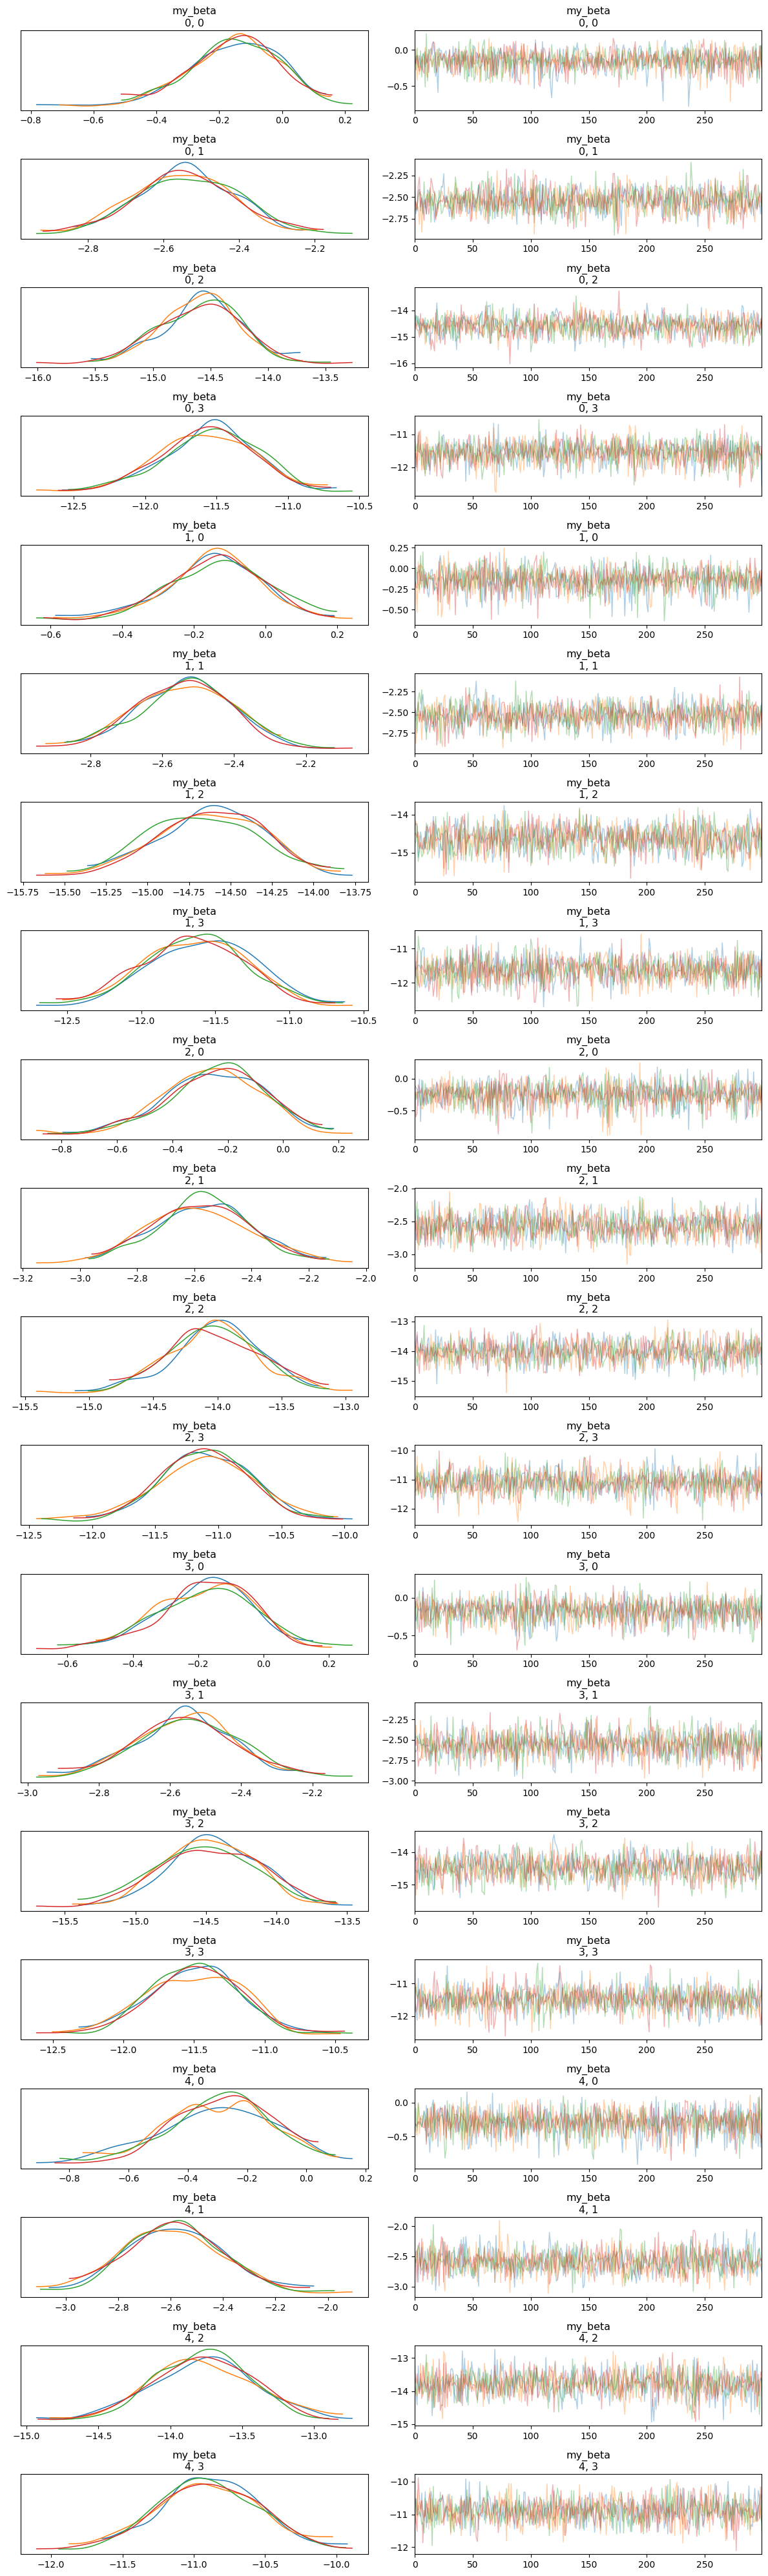

In [29]:
az.rcParams['plot.max_subplots'] = 40  # Adjust this value according to your needs
az.plot_trace(cmdstanpy_data, compact=False)
plt.tight_layout()

# 16.5 CREDIBLE INTERVALS BETA

In [30]:
q1 = np.zeros(40)
q2= np.zeros(40)
q3= np.zeros(40)
posterior = fit.stan_variable(var="my_beta")[:,:, 0]
mybeta1_quantile = []
for i in range(40):
    q1[i]= np.quantile(posterior[:,i], 0.025)
    q2[i]= np.quantile(posterior[:,i], 0.5)
    q3[i]= np.quantile(posterior[:,i], 0.975)
    mybeta1_quantile.append((posterior[:,i]).tolist())

In [31]:
def plot_credible_interval(x,values,horizontal_line_width=0.25):
    median = np.quantile(values, 0.5)
    left = x - horizontal_line_width / 2
    bottom = np.quantile(values, 0.025)
    right = x + horizontal_line_width / 2
    top = np.quantile(values, 0.975)
    credible_interval = [bottom, top]
    plt.plot([x, x], [top, bottom],color='red')
    plt.plot([left, right], [top, top],color='red')
    plt.plot([left, right], [bottom, bottom],color='red')
    plt.plot(x, median, 'o',color='red')
    return median, credible_interval

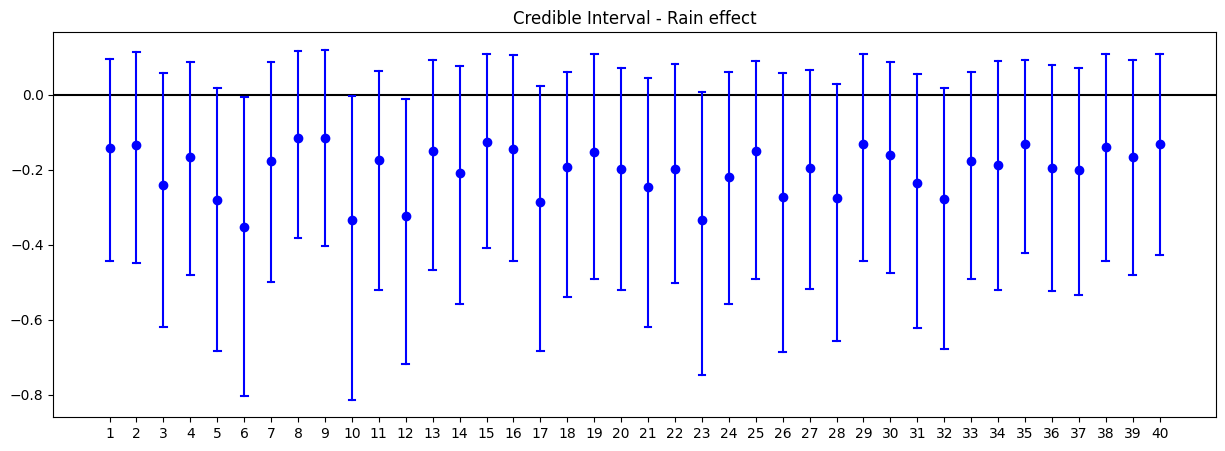

In [41]:
import matplotlib.patches as mpatches
plt.figure(figsize=(15, 5))
plt.xticks(np.arange(40)+1)
plt.title('Credible Interval - Rain effect')
plt.axhline(y=0, color= 'black')

for i in range(40):
 plot_credible_interval(i+1, mybeta1_quantile[i][:])
#plt.savefig('/content/drive/MyDrive/Progetto/modelli+plot/effetto_pioggia.png')
plt.show()

In [33]:
q1 = np.zeros(40)
q2= np.zeros(40)
q3= np.zeros(40)
posterior = fit.stan_variable(var="my_beta")[:,:, 1]
mybeta2_quantile = []
for i in range(40):
    q1[i]= np.quantile(posterior[:,i], 0.025)
    q2[i]= np.quantile(posterior[:,i], 0.5)
    q3[i]= np.quantile(posterior[:,i], 0.975)
    mybeta2_quantile.append((posterior[:,i]).tolist())

In [34]:
def plot_credible_interval(x,values,horizontal_line_width=0.25):
    median = np.quantile(values, 0.5)
    left = x - horizontal_line_width / 2
    bottom = np.quantile(values, 0.025)
    right = x + horizontal_line_width / 2
    top = np.quantile(values, 0.975)
    credible_interval = [bottom, top]
    plt.plot([x, x], [top, bottom],color='blue')
    plt.plot([left, right], [top, top],color='blue')
    plt.plot([left, right], [bottom, bottom],color='blue')
    plt.plot(x, median, 'o',color='blue')
    return median, credible_interval

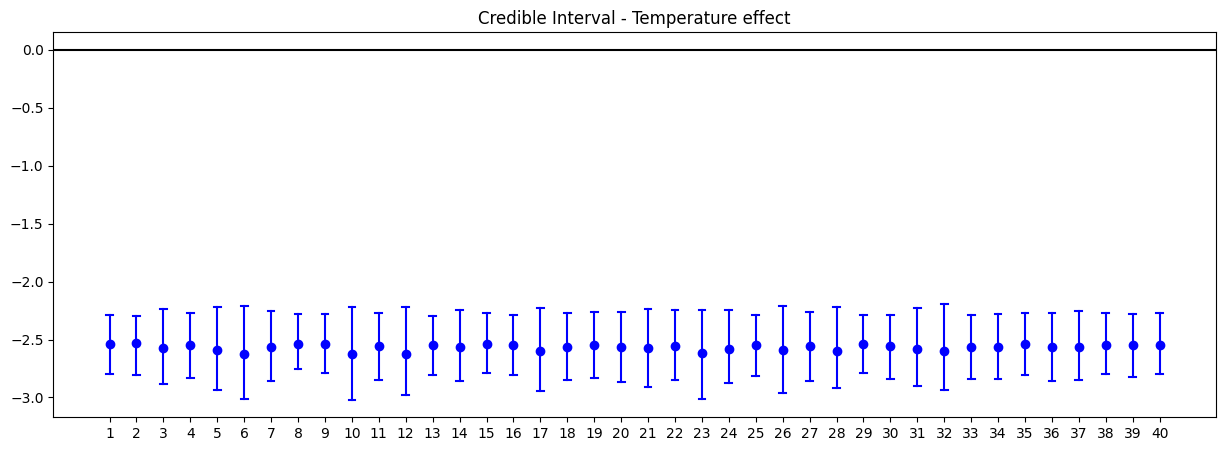

In [39]:
plt.figure(figsize=(15, 5))
plt.xticks(np.arange(40)+1)
plt.title('Credible Interval - Temperature effect')
plt.axhline(y=0, color= 'black')

for i in range(40):
 plot_credible_interval(i+1, mybeta2_quantile[i][:])
#plt.savefig('/content/drive/MyDrive/Progetto/modelli+plot/effetto_temp.png')  # Cambia il nome se no sovrascrive
plt.show()